In [1]:
%matplotlib inline
from datetime import date, timedelta, datetime
import gc
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
# import xgboost as xgb

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization,Reshape
from keras.layers import PReLU, LSTM, Conv1D, concatenate,Flatten, CuDNNGRU, Add
from keras import callbacks,optimizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

/home/bingo/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/bingo/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
 
KTF.set_session(tf.Session(config=tf.ConfigProto(device_count={'gpu':0})))

In [3]:
import os
rootpath = r"/home/bingo/桌面/sales_forecasting/steel_storage_throughput_prediction"
os.chdir(rootpath)
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

### selecting data
- 加载表格，库存数据集、储户费用数据集、出入库训练集
- 预测任务
    - 1.按照两大类货品类型（冷卷、热卷），分别预测未来4个周钢铁的周入库量和周出库量（重量）；
    - 2.按照两大类货品类型（冷卷、热卷），分别预测未来i天的日入库量和日出库量（重量）。
- 只有产品名称是热卷和圆钢为热卷类型，其余均为冷卷类型
- 整理目标：仅筛选出包含冷卷和热卷两种货品的数据集，添加新列表示冷卷或热卷

### loading data
- 加载表格：加载提取后的出入库数据集
- 整理目标
    - 转换为储户id-产品id-日期格式三层索引，做为训练集格式
    - 无记录时间记出入库重量为0
    - 补齐中断的缺失时间，时间范围为(2014-02-24,2018-01-28)

### data extraction
- 特征提取
- 滑窗选取数据集
- 有大量0数值，稀疏数据
- 以4周数据，预测下一周i天数据
- 时间点
    - 测试集：2018-01-28
    - 验证集：2018-01-21
    - 训练集：2018-01-14

In [4]:
# 合并含有大量0值的行
def merge_zeros_cols(df, merge_end=500, merge_step=50):
    freq = df.columns.freqstr
    # 添加一列统计每行0值，用于合并
    notzeros = np.count_nonzero(df, axis=1)
    merge_list = np.arange(0,merge_end+1,merge_step)
    df = df.reset_index()
    # 不用合并的行
    df_ = df[notzeros>=merge_end].set_index("type_id")
    for i, value in enumerate(merge_list[:-1]):
        # 待合并行的布尔索引
        ind = (notzeros>=value)&(notzeros<merge_list[i+1])
        tmp = df.iloc[ind,:]
        tmp = tmp.groupby("type_id").sum(axis=0)
        tmp["store_id"] = merge_list[i+1]
        df_ = pd.concat([df_,tmp],axis=0)
#     df_ = df_.drop("notzeros",axis=0)
    df_ = df_.reset_index().set_index(["store_id","type_id"])
    df_.columns = pd.DatetimeIndex(df_.columns,freq=freq)
    return df_

In [5]:
def cnt_zeros(df):
    notzeros = np.count_nonzero(df,axis=1)
    zeros = df.shape[1]-notzeros
    zeros_ratio = zeros/df.shape[1]
    pd.Series(zeros_ratio).hist()

####  导入数据

In [6]:
# 导入数据集，保持稀疏性
# converters={"unit_sales":lambda x:np.log1p(float(x)) if float(x)>0 else 0}
span = 30

df_train_in = pd.read_csv("data/train_in_all.csv").set_index(["store_id","type_id"])
df_train_in.columns = pd.to_datetime(df_train_in.columns)
df_train_in.columns.name = "date"

df_train_ext = pd.read_csv("data/train_ext_all.csv").set_index(["store_id","type_id"])
df_train_ext.columns = pd.to_datetime(df_train_ext.columns)
df_train_ext.columns.name = "date"

df_train_in = df_train_in/1000
df_train_ext = df_train_ext/1000

df_train_in_nums = pd.read_csv("data/train_in_all_nums.csv").set_index(["store_id","type_id"])/1000
df_train_in_nums.columns = pd.to_datetime(df_train_in_nums.columns)
df_train_in_nums.columns.name = "date"

df_train_ext_nums = pd.read_csv("data/train_ext_all_nums.csv").set_index(["store_id","type_id"])/1000
df_train_ext_nums.columns = pd.to_datetime(df_train_ext_nums.columns)
df_train_ext_nums.columns.name = "date"

df_train_in = df_train_in.ewm(span=span, axis=1).mean()
df_train_ext = df_train_ext.ewm(span=span, axis=1).mean()
df_train_in_nums = df_train_in_nums.ewm(span=span, axis=1).mean()
df_train_ext_nums = df_train_ext_nums.ewm(span=span, axis=1).mean()

print("df_train_in shape: ", df_train_in.shape)
print("df_train_ext_shape: ", df_train_ext.shape)
print("df_train_in_nums shape: ", df_train_in_nums.shape)
print("df_train_ext_nums shape: ", df_train_ext_nums.shape)

df_train_in shape:  (1219, 1463)
df_train_ext_shape:  (1213, 1463)
df_train_in_nums shape:  (1219, 1463)
df_train_ext_nums shape:  (1213, 1463)


#### 周/天数据整理

In [7]:
# 取对数后重采样, 若先重采样再取对数则会预测值过大exp溢出
# 150-50,(128,155); 200-100,(87,122);500-100,(37,57)

# 有差分：合并->取对数->重采样->差分, 独立做一遍
tmp_in = merge_zeros_cols(df_train_in, 500, 100).transpose()
df_train_in_transpose = tmp_in

tmp_ext = merge_zeros_cols(df_train_ext, 500, 100).transpose()
df_train_ext_transpose = tmp_ext

tmp_in_nums = merge_zeros_cols(df_train_in_nums, 500, 100).transpose()
df_train_in_nums_transpose = tmp_in_nums

tmp_ext_nums = merge_zeros_cols(df_train_ext_nums, 500, 100).transpose()
df_train_ext_nums_transpose = tmp_ext_nums

# 按周重采样
df_train_in_W = df_train_in_transpose.resample("W",closed="right",label="right").mean().transpose()
df_train_in_2W = df_train_in_transpose.resample("2W",closed="right",label="right").mean().transpose()
df_train_in_3W = df_train_in_transpose.resample("3W",closed="right",label="right").mean().transpose()
df_train_in_4W = df_train_in_transpose.resample("4W",closed="right",label="right").mean().transpose()

df_train_ext_W = df_train_ext_transpose.resample("W",closed="right",label="right").mean().transpose()
df_train_ext_2W = df_train_ext_transpose.resample("2W",closed="right",label="right").mean().transpose()
df_train_ext_3W = df_train_ext_transpose.resample("3W",closed="right",label="right").mean().transpose()
df_train_ext_4W = df_train_ext_transpose.resample("4W",closed="right",label="right").mean().transpose()

# 数量重采样
df_train_in_nums_W = df_train_in_nums_transpose.resample("W",closed="right",label="right").mean().transpose()
df_train_in_nums_2W = df_train_in_nums_transpose.resample("2W",closed="right",label="right").mean().transpose()
df_train_in_nums_3W = df_train_in_nums_transpose.resample("3W",closed="right",label="right").mean().transpose()
df_train_in_nums_4W = df_train_in_nums_transpose.resample("4W",closed="right",label="right").mean().transpose()

df_train_ext_nums_W = df_train_ext_nums_transpose.resample("W",closed="right",label="right").mean().transpose()
df_train_ext_nums_2W = df_train_ext_nums_transpose.resample("2W",closed="right",label="right").mean().transpose()
df_train_ext_nums_3W = df_train_ext_nums_transpose.resample("3W",closed="right",label="right").mean().transpose()
df_train_ext_nums_4W = df_train_ext_nums_transpose.resample("4W",closed="right",label="right").mean().transpose()

print("df_train_in_W shape: ",df_train_in_W.shape)
print("df_train_ext_W shape: ",df_train_ext_W.shape)
print("df_train_in_nums_W shape: ",df_train_in_nums_W.shape)
print("df_train_ext_nums_W shape: ",df_train_ext_nums_W.shape)

df_train_in_W shape:  (645, 209)
df_train_ext_W shape:  (631, 209)
df_train_in_nums_W shape:  (645, 209)
df_train_ext_nums_W shape:  (631, 209)


In [8]:
# 对于天数据，合并->取对数->差分
# 先合并数据行
df_train_in = merge_zeros_cols(df_train_in, merge_end=500, merge_step=50*2)#/1000 #100
df_train_ext = merge_zeros_cols(df_train_ext, merge_end=500, merge_step=50*2)#/1000 #500,100

# 再直接取对数
df_train_in = df_train_in
df_train_ext = df_train_ext

# 数量处理
df_train_in_nums = merge_zeros_cols(df_train_in_nums, merge_end=500, merge_step=50*2)#/1000 #100
df_train_ext_nums = merge_zeros_cols(df_train_ext_nums, merge_end=500, merge_step=50*2)#/1000 #500,100

# 再直接取对数
# df_train_in_nums = np.log1p(df_train_in_nums)
# df_train_ext_nums = np.log1p(df_train_ext_nums)

print("df_train_in shape: ", df_train_in.shape)
print("df_train_ext_shape: ", df_train_ext.shape)

df_train_in shape:  (645, 1463)
df_train_ext_shape:  (631, 1463)


### 算法建模_byDay

#### 训练集数据整理

In [9]:
def create_dataset_byday(df, dnums, dt, timesteps, freq="D", futures=7, is_train=True):
    x = df[pd.date_range(dt-timedelta(timesteps-1), periods=timesteps, freq=freq)]
    x_nums = dnums[pd.date_range(dt-timedelta(timesteps-1), periods=timesteps, freq=freq)].values
    dtype = x.reset_index()[["type_id"]].values
    x = x.values
    
    dims = x.shape
    x = x.reshape(dims[0], dims[1], 1)
    x_nums = x_nums.reshape(dims[0], dims[1], 1)
    x = np.concatenate([x, x_nums], axis=-1)
#     dtype = dtype.reshape(dims[0],1,1)
#     x = np.concatenate([x, dtype], axis=1)
    
    if is_train:
        y = df[pd.date_range(dt+timedelta(1), periods=futures)]
        return x, y
    return x

In [10]:
def train_generator_byday(df, dnums, dt, nums, timesteps, futures=7):
    freq = df.columns.freqstr
    while 1:
        for i in range(nums):
            pred_start = dt-timedelta(days=i)
            yield create_dataset_byday(df, dnums, pred_start, timesteps, freq, futures)

In [11]:
timesteps = 7*15 #7*8
num_days = 7*30 #7*20
train_day = pd.concat([df_train_in, df_train_ext], axis=0)
train_nums = pd.concat([df_train_in_nums, df_train_ext_nums], axis=0)

tval = date(2018, 1, 21)
x_val, y_val = create_dataset_byday(train_day, train_nums, tval, timesteps=timesteps, is_train=True)

ttest = date(2018, 1, 28)
x_test = create_dataset_byday(train_day, train_nums, ttest, timesteps=timesteps, is_train=False)
print("x_test shape: ",x_test.shape)

x_test shape:  (1276, 105, 2)


####  模型构建

In [12]:
def model_byday(timesteps, feadims, outdim):
    seq = Input(shape=(timesteps, feadims))
    latentdims = 16
    ks = 2
    c1 = Conv1D(8, 1, activation="relu")(seq)
    
    c2 = Conv1D(latentdims, ks, dilation_rate=1, padding="causal", activation="relu")(c1)
    c3 = Conv1D(latentdims*2, ks, dilation_rate=2, padding="causal", activation="relu")(c2)
    c4 = Dropout(0.1)(c3)
    c4 = Conv1D(latentdims*4, ks, dilation_rate=2, padding="causal", activation="relu")(c4)
    c5 = Conv1D(latentdims*8, ks, dilation_rate=2, padding="causal", activation="relu")(c4)
    c6 = Dropout(0.1)(c5)
    c6 = Conv1D(latentdims*16, ks, dilation_rate=2, padding="causal", activation="relu")(c6)
    
    c7 = Conv1D(latentdims*32, ks, dilation_rate=2, padding="causal", activation="relu")(c6)
    
    up6 = Conv1D(latentdims*16, ks, dilation_rate=2, padding="causal", activation="relu")(c7)
    up5 = Conv1D(latentdims*8, ks, dilation_rate=2, padding="causal", activation="relu")(Add()([up6, c6]))
    up4 = Conv1D(latentdims*4, ks, dilation_rate=2, padding="causal", activation="relu")(Add()([up5, c5]))
    up3 = Conv1D(latentdims*2, ks, dilation_rate=2, padding="causal", activation="relu")(Add()([up4, c4]))
    up2 = Conv1D(latentdims, ks, dilation_rate=1, padding="causal", activation="relu")(Add()([up3, c3]))
    
    c3 = Conv1D(8, 1, activation="relu")(Add()([up2,c2]))
    c3 = Dropout(0.1)(c3)
    c4 = Add()([c1, c3])
#     c4 = concatenate([c1, c3])

#     c3 = concatenate([c1,c2])
#     c4 = Conv1D(8*2, 1, activation="relu")(c3)
    
    d1 = Dropout(0.1)(c4)
    d1 = Dense(512//16, activation="relu")(Flatten()(d1))
#     d1 = Dense(256//4,activation="relu")(d1)
#     d1 = Dense(128//4, activation="relu")(d1)
    
    output = Dense(outdim, activation="relu")(d1)
    model = Model(inputs=seq, outputs=output)
    return model

In [13]:
def model_byday(timesteps, feadims, outdim):
    seq = Input(shape=(timesteps, feadims))
    latentdims = 32
    ks = 2
    c1 = Conv1D(latentdims, ks, dilation_rate=1, padding="causal", activation="relu")(seq)
    c2 = Conv1D(latentdims, ks, dilation_rate=2, padding="causal", activation="relu")(c1)
    c2 = Conv1D(latentdims, ks, dilation_rate=4, padding="causal", activation="relu")(c2)
    c2 = Conv1D(latentdims, ks, dilation_rate=8, padding="causal", activation="relu")(c2)

    c3 = concatenate([c1,c2])

    c4 = Conv1D(8, 1, activation="relu")(c3)

    d1 = Dropout(0.1)(c4)
    d1 = Dense(512,activation="relu")(Flatten()(d1))
    d1 = Dense(256, activation="relu")(d1)

    output = Dense(outdim, activation="relu")(d1)
    model = Model(inputs=seq, outputs=output)
    return model

In [14]:
n = 1
t2018 = date(2018, 1, 14)+timedelta(28*n)

# timesteps = 7*4

N_EPOCHS = 500
feadims = 2
outdim = 7

training model  2018-12-24 16:19:47.695788
Epoch 1/500
 - 2s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 2/500
 - 0s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 3/500
 - 0s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 4/500
 - 0s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 7.4109e-04 - val_mean_squared_error: 7.4109e-04
Epoch 5/500
 - 0s - loss: 9.0631e-04 - mean_squared_error: 9.0631e-04 - val_loss: 7.3111e-04 - val_mean_squared_error: 7.3111e-04
Epoch 6/500
 - 0s - loss: 5.8533e-04 - mean_squared_error: 5.8533e-04 - val_loss: 4.7260e-04 - val_mean_squared_error: 4.7260e-04
Epoch 7/500
 - 0s - loss: 4.5292e-04 - mean_squared_error: 4.5292e-04 - val_loss: 3.8666e-04 - val_mean_squared_error: 3.8666e-04
Epoch 8/500
 - 0s - loss: 3.9844e-04 - mean_squared_error: 3.9844e-04 - val_loss: 4.1770e-04 - val_mean

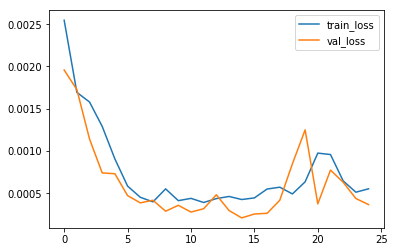

In [15]:
if not os.path.exists(r"./model/model2"):
    os.mkdir(r"./model/model2")

train_gene = train_generator_byday(train_day, train_nums, t2018, num_days, timesteps)

modelday = model_byday(timesteps, feadims, outdim)

print("="*50)
print("training model ", datetime.now())
print("="*50)
opt = optimizers.Adam(lr=0.001)
modelday.compile(loss="mse", optimizer=opt, metrics=["mse"])
callbacks_fn = [
        EarlyStopping(monitor="val_loss", patience=10, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=7,\
                          verbose=1, min_delta=1e-6, mode="min")
    ]
    
history = modelday.fit_generator(train_gene, epochs=N_EPOCHS, steps_per_epoch=3,
      verbose=2, validation_data=(x_val, y_val), callbacks=callbacks_fn)

val_pred = modelday.predict(x_val)
modelday.save(r"./model/model2/bst_byday"+".hdf5")
plt.plot(history.history["loss"],label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

In [16]:
modelday.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 2)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 105, 32)      160         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 105, 32)      2080        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 105, 32)      2080        conv1d_2[0][0]                   
__________________________________________________________________________________________________
conv1d_4 (

### 算法建模_byWeek

#### 训练集数据整理

In [17]:
def create_dataset_byweek(df, dnums, dt, timesteps, freq=None, steps=7, futures=1, is_train=True):
    if not freq:
        freq = df.columns.freqstr
    x = df[pd.date_range(dt-timedelta(int(timesteps*steps)), periods=timesteps, freq=freq)]
    x_nums = dnums[pd.date_range(dt-timedelta(int(timesteps*steps)), periods=timesteps, freq=freq)].values
    dtype = x.reset_index()[["type_id"]].values
    x = x.values
    
    dims = x.shape
    x = x.reshape(dims[0], dims[1], 1)
    x_nums = x_nums.reshape(dims[0], dims[1], 1)
    x = np.concatenate([x, x_nums], axis=-1)
    
    if is_train:
        y = df[pd.date_range(dt, periods=futures)]
        return x, y
    return x

In [18]:
def train_generator_byweek(df, dnums, dt, nums, timesteps, steps=1, futures=1):
    freq = df.columns.freqstr
    while 1:
        for i in range(nums):
            pred_start = dt-timedelta(days=int(i*steps))
            yield create_dataset_byweek(df, dnums, pred_start, timesteps, freq, steps, futures)

In [19]:
train_W = pd.concat([df_train_in_W, df_train_ext_W], axis=0)
train_2W = pd.concat([df_train_in_2W, df_train_ext_2W], axis=0) 
train_3W = pd.concat([df_train_in_3W, df_train_ext_3W], axis=0)
train_4W = pd.concat([df_train_in_4W, df_train_ext_4W], axis=0)
train_Wall = [train_W, train_2W, train_3W, train_4W]

train_nums_W = pd.concat([df_train_in_nums_W, df_train_ext_nums_W], axis=0)
train_nums_2W = pd.concat([df_train_in_nums_2W, df_train_ext_nums_2W], axis=0) 
train_nums_3W = pd.concat([df_train_in_nums_3W, df_train_ext_nums_3W], axis=0)
train_nums_4W = pd.concat([df_train_in_nums_4W, df_train_ext_nums_4W], axis=0)
train_nums_Wall = [train_nums_W, train_nums_2W, train_nums_3W, train_nums_4W]
print("train_nums_W shape: ", train_nums_W.shape)
print("train_nums_2W shape: ", train_nums_2W.shape)

train_nums_W shape:  (1276, 209)
train_nums_2W shape:  (1276, 105)


In [20]:
# test_date=["2018-02-03", "2018-02-10", "2018-02-17", "2018-02-24"]
i=-1
val_date = [
    df_train_in_W.columns[i],
    df_train_in_2W.columns[i],
    df_train_in_3W.columns[i],
    df_train_in_4W.columns[i]
]  

test_date = []
steps = [7,14,21,28]
for i in range(4):
    test_date.append(val_date[i] + timedelta(steps[i]))
    
timesteps = 7*3 #14
num_weeks = 7*3 #25

ttest_W = datetime.strptime(test_date[0], "%Y-%m-%d") if isinstance(test_date[0], str) else test_date[0]
x_test_W = create_dataset_byweek(train_Wall[0], train_nums_Wall[0],
                                 ttest_W, timesteps, steps=steps[0], futures=1, is_train=False)

ttest_2W = datetime.strptime(test_date[1], "%Y-%m-%d") if isinstance(test_date[1], str) else test_date[1]
x_test_2W = create_dataset_byweek(train_Wall[1], train_nums_Wall[1], 
                                  ttest_2W, timesteps, steps=steps[1], futures=1, is_train=False)

ttest_3W = datetime.strptime(test_date[2], "%Y-%m-%d") if isinstance(test_date[2], str) else test_date[2]
x_test_3W = create_dataset_byweek(train_Wall[2], train_nums_Wall[2],
                                  ttest_3W, timesteps, steps=steps[2], futures=1, is_train=False)

ttest_4W = datetime.strptime(test_date[3], "%Y-%m-%d") if isinstance(test_date[3], str) else test_date[3]
x_test_4W = create_dataset_byweek(train_Wall[3], train_nums_Wall[3],
                                  ttest_4W, timesteps, steps=steps[3], futures=1, is_train=False)
print("x_test_W shape: ", x_test_W.shape)

x_test_W shape:  (1276, 21, 2)


####  模型构建

In [21]:
def model_byweek(timesteps, feadims, outdim):
    seq = Input(shape=(timesteps, feadims))
    latentdims = 16
    ks = 2
    c1 = Conv1D(8, 1, activation="relu")(seq)
    
    c2 = Conv1D(latentdims, ks, dilation_rate=1, padding="causal", activation="relu")(c1)
    c3 = Conv1D(latentdims*2, ks, dilation_rate=2, padding="causal", activation="relu")(c2)
    c4 = Dropout(0.1)(c3)
    c4 = Conv1D(latentdims*4, ks, dilation_rate=2, padding="causal", activation="relu")(c4)
    c5 = Conv1D(latentdims*8, ks, dilation_rate=2, padding="causal", activation="relu")(c4)
#     c6 = Dropout(0.1)(c5)
#     c6 = Conv1D(latentdims*16, ks, dilation_rate=2, padding="causal", activation="relu")(c6)
    
    c7 = Conv1D(latentdims*16, ks, dilation_rate=2, padding="causal", activation="relu")(c5)
    
#     up6 = Conv1D(latentdims*16, ks, dilation_rate=2, padding="causal", activation="relu")(c7)
    up5 = Conv1D(latentdims*8, ks, dilation_rate=2, padding="causal", activation="relu")(c7)#(Add()([up6, c6]))
    up4 = Conv1D(latentdims*4, ks, dilation_rate=2, padding="causal", activation="relu")(Add()([up5, c5]))
    up3 = Conv1D(latentdims*2, ks, dilation_rate=2, padding="causal", activation="relu")(Add()([up4, c4]))
    up2 = Conv1D(latentdims, ks, dilation_rate=1, padding="causal", activation="relu")(Add()([up3, c3]))
    
    c3 = Conv1D(8, 1, activation="relu")(Add()([up2,c2]))
    
    c4 = Add()([c1, c3])

    #     c3 = concatenate([c1, c2])

#     c4 = Conv1D(8//2, 1, activation="relu")(c3)

    d1 = Dropout(0.1)(c4)
    d1 = Dense(512//32, activation="relu")(Flatten()(d1))
#     d1 = Dense(256//32, activation="relu")(d1)
#     d1 = Dense(256, activation="relu")(d1)
#     d1 = Dense(128, activation="relu")(d1)

    output = Dense(outdim, activation="relu")(d1)
    model = Model(inputs=seq, outputs=output)
    return model

In [22]:
def model_byweek(timesteps, feadims, outdim):
    seq = Input(shape=(timesteps, feadims))
    latentdims = 32
    ks = 2
    c1 = Conv1D(latentdims, ks, dilation_rate=1, padding="causal", activation="relu")(seq)
    c2 = Conv1D(latentdims, ks, dilation_rate=2, padding="causal", activation="relu")(c1)
    c2 = Conv1D(latentdims, ks, dilation_rate=4, padding="causal", activation="relu")(c2)
    c3 = concatenate([c1, c2])

    c4 = Conv1D(8, 1, activation="relu")(c3)

    d1 = Dropout(0.1)(c4)
    d1 = Dense(512, activation="relu")(Flatten()(d1))
    d1 = Dense(256, activation="relu")(d1)

    output = Dense(outdim, activation="relu")(d1)
    model = Model(inputs=seq, outputs=output)
    return model

In [23]:
# train_date = ['2018-01-21','2018-01-14', '2018-01-07', '2017-12-31']
# val_date = ['2018-01-28', '2018-01-28', '2018-01-28', '2018-01-28']

i = -2
train_date = [
    df_train_in_W.columns[i],
    df_train_in_2W.columns[i],
    df_train_in_3W.columns[i],
    df_train_in_4W.columns[i]
]

i=-1
val_date = [
    df_train_in_W.columns[i],
    df_train_in_2W.columns[i],
    df_train_in_3W.columns[i],
    df_train_in_4W.columns[i]
]  

steps = [7,14,21,28]
N_EPOCHS = 1000
feadims = 2
outdim = 1
val_pred_W = []

model_1
training model  2018-12-24 16:19:54.316114
Epoch 1/1000
 - 1s - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 2/1000
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/1000
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 4/1000
 - 0s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 5/1000
 - 0s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 6/1000
 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 7/1000
 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 8/1000
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 9.5275e-04 - val_mean_squared_error: 9.5275e-04
Epoch 9/1000
 - 0s - 

Epoch 4/1000
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 5/1000
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 6/1000
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 7/1000
 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 8/1000
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 9/1000
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 10/1000
 - 0s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 11/1000
 - 0s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 12/1000
 - 0s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.

Epoch 53/1000
 - 0s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 54/1000
 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 55/1000
 - 0s - loss: 5.5964e-04 - mean_squared_error: 5.5964e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 56/1000
 - 0s - loss: 5.2315e-04 - mean_squared_error: 5.2315e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 57/1000
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 58/1000
 - 0s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 59/1000
 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 60/1000
 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 61/1000
 - 0s - loss: 0.0010 - mean_squared_error:

Epoch 121/1000
 - 0s - loss: 7.9392e-04 - mean_squared_error: 7.9392e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 122/1000
 - 0s - loss: 8.1425e-04 - mean_squared_error: 8.1425e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 123/1000
 - 0s - loss: 9.7323e-04 - mean_squared_error: 9.7323e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 124/1000
 - 0s - loss: 6.6029e-04 - mean_squared_error: 6.6029e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 125/1000
 - 0s - loss: 4.1530e-04 - mean_squared_error: 4.1530e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 126/1000
 - 0s - loss: 4.7939e-04 - mean_squared_error: 4.7939e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 127/1000
 - 0s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 128/1000
 - 0s - loss: 7.5555e-04 - mean_squared_error: 7.5555e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 12

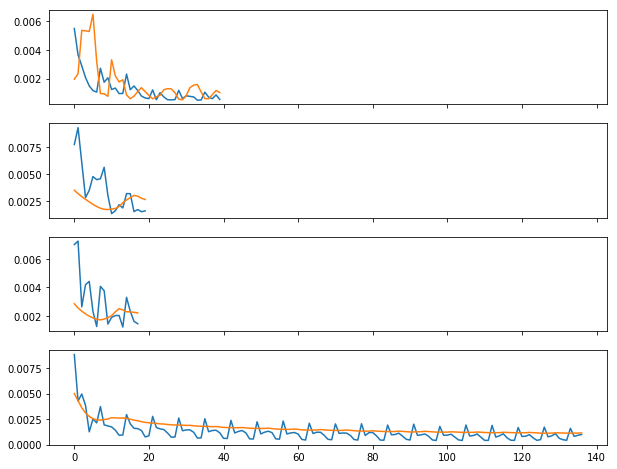

In [24]:
if not os.path.exists(r"./model/model2"):
    os.mkdir(r"./model/model2")
    
lr = [0.001, 0.0001, 0.0001, 0.0001]
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))
for i in range(4):
    t2018_W = datetime.strptime(train_date[i], "%Y-%m-%d") if isinstance(train_date[i],str) else train_date[i]
    train_geneW = train_generator_byweek(train_Wall[i], train_nums_Wall[i], 
                                         t2018_W, num_weeks, timesteps, steps[i], futures=1)
    
    tval_W = datetime.strptime(val_date[i], "%Y-%m-%d") if isinstance(val_date[i], str) else val_date[i]
    x_val_W, y_val_W = create_dataset_byweek(train_Wall[i], train_nums_Wall[i], 
                                             tval_W, timesteps, steps=steps[i], futures=1)
    
    print("="*50)
    print("model_%s"%(i+1))
    print("training model ", datetime.now())
    print("="*50)
    
    modelweek = model_byweek(timesteps, feadims, outdim)
    opt = optimizers.Adam(lr=lr[i])
    modelweek.compile(loss="mse", optimizer=opt, metrics=["mse"])
    callbacks_fn = [
        EarlyStopping(monitor="val_loss", patience=10, verbose=50),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7,\
                          verbose=10, min_delta=1e-6, mode="min")
    ]
    
    history = modelweek.fit_generator(train_geneW, epochs=N_EPOCHS, steps_per_epoch=3,
      verbose=2, validation_data=(x_val_W, y_val_W), callbacks=callbacks_fn)

    val_pred_W.append(modelweek.predict(x_val_W))
    modelweek.save(r"./model/model2/bst_byweek%s"%(i+1)+".hdf5")
    
    ax[i].plot(history.history["loss"], label="train_loss%d"%(i))
    ax[i].plot(history.history["val_loss"], label="val_loss%d"%(i))

In [25]:
modelweek.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 21, 2)        0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 21, 32)       160         input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 21, 32)       2080        conv1d_18[0][0]                  
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 21, 32)       2080        conv1d_19[0][0]                  
__________________________________________________________________________________________________
concatenat

### 算法评估标准

In [26]:
def getPrediction(preds, inds, steps=[4,4,7,7]):
    # preds=[week_ext, week_in, day_ext, day_in]
    stack = []
    for ind,pred,step in zip(inds, preds, steps):
        pred = np.array(pred).squeeze().transpose()
        tmp = pd.DataFrame(np.expm1(pred), index=ind)
        tmp = tmp.reset_index().drop("store_id",axis=1)
        tmp = tmp.groupby("type_id").sum().values[::-1]
        tmp = tmp.reshape(2*step)
        stack.append(tmp)
    stack_pred = np.concatenate(stack, axis=0)
    return stack_pred

In [27]:
def getSMAPE(label, pred, inds):
    M = 800
    t = getPrediction(label, inds)*1000
    p = getPrediction(pred, inds)*1000
    print((t-p)/t)
    smape = np.mean(np.abs((t - p)/(np.maximum((t+p)/2,M))))
    mape = np.mean(np.abs((t-p)/t))
#     mse = np.mean(np.power(t-p,2))
#     mae = np.mean(np.abs(t-p))
    score = (2-smape)*50
    print("get MAPE %.4f"%(mape))
#     print("get MSE %.4f"%(mse))
#     print("get MAE %.4f"%(mae))
    print("get SMAPW %.4f"%(smape))
    print("get score %.4f"%(score))
    return smape,score

In [28]:
def getLastW(data):
    d1 = np.array(data).squeeze().transpose()
    # 先差分
    d2 = np.expm1(d1)*np.array([7,14,21,28]) #d2 = np.expm1(d1)*np.array([7,14,21,28])
    d3 = np.diff(d2, axis=1)
#     d3[d3<0] = 0
    d2[:,1:]= d3
    d2 = np.clip(d2,0,None)
    res = np.log1p(d2).transpose()
    return res

In [29]:
np.array(val_pred).shape

(1276, 7)

### 预测提交

In [30]:
def prediction_dnn(test, path="./model/model2",mode="wd"):
    # test=[test_ext_w, test_in_w, test_ext_day, test_in_day]
    # test=[W, W2, W3, W4]
    if mode=="wd":
        week_ext, week_in, day_ext, day_in = [], [], [], []
        results = [week_ext, week_in, day_ext, day_in]
        # bases = ["bst_byweek%s.hdf5","bst_byweek%s.hdf5","bst_byday%s.hdf5","bst_byday%s.hdf5"]
        bases = [[],[],"bst_byday.hdf5","bst_byday.hdf5"]
        steps = [0,0,1,1]
        for step, res, base, data in zip(steps, results, bases, test):
            dtest = data#.reshape(data.shape[0], 1, data.shape[1])
            for i in range(step):
                mpath = os.path.join(path, base)
                print(mpath)
                model = load_model(mpath)
                res.append((model.predict(dtest)).transpose())
    else:
        W, W2, W3, W4 = [], [], [], []
        results = [W, W2, W3, W4]
        bases = ["bst_byweek%s.hdf5"]*4
        steps = range(4)
        for step, res, base, data in zip(steps, results, bases, test):
            dtest = data#.reshape(data.shape[0], 1, data.shape[1])
            mpath = os.path.join(path, base%(step+1))
            print(mpath)
            model = load_model(mpath)
            res.append(model.predict(dtest))
    return results

In [31]:
def makeSubmission(preds, inds, steps=[4,4,7,7], filename="./submission/result.csv"):
    # preds=[week_ext, week_in, day_ext, day_in]
    stack = []
    for ind,pred,step in zip(inds, preds, steps):
        pred = np.array(pred).squeeze().transpose()
#         tmp = pd.DataFrame(np.expm1(pred), index=ind)
        tmp = pd.DataFrame(pred, index=ind)
        tmp = tmp.reset_index().drop("store_id",axis=1)
        tmp = tmp.groupby("type_id").sum().values[::-1]
        tmp = tmp.reshape(2*step)
        stack.append(tmp)
    stack_pred = np.concatenate(stack, axis=0)
    stack_pred = stack_pred*1000
    result = pd.read_csv("./submission/result_org.csv")
    result["VALUE"] = stack_pred
    result.to_csv(filename,float_format="%.4f",index=False)
    print("done!")
    return stack_pred

In [32]:
def getLastW(data):
    d1 = np.array(data).squeeze().transpose()
    # 先差分
#     d2 = np.expm1(d1)*np.array([7,14,21,28]) #d2 = np.expm1(d1)*np.array([7,14,21,28])
    d2 = d1*np.array([7,14,21,28])
    d3 = np.diff(d2, axis=1)
#     d3[d3<0] = 0
    d2[:,1:]= d3
    d2 = np.clip(d2,0,None)
#     res = np.log1p(d2).transpose()
    res = d2.transpose()
    return res

#### 4周累积

In [36]:
%time
sp = df_train_in_W.shape[0]
# preds=[week_ext, week_in, day_ext, day_in]

x_test_in_Wall = [x_test_W[:sp], x_test_2W[:sp], x_test_3W[:sp], x_test_4W[:sp]]
x_test_ext_Wall = [x_test_W[sp:], x_test_2W[sp:], x_test_3W[sp:], x_test_4W[sp:]]

test = [[], [], x_test[sp:], x_test[:sp]]
mpath = './model/model2'
res_ext_W = prediction_dnn(x_test_ext_Wall,path=mpath,mode="w")
res_in_W = prediction_dnn(x_test_in_Wall,path=mpath, mode="w")
res = prediction_dnn(test,path=mpath)

# -----------------------无差分时使用-------------------------------
# 求各周
res1 = getLastW(res_ext_W)
res2 = getLastW(res_in_W)
results = [res1,res2,res[2],res[3]]

inds = [df_train_ext_W.index, df_train_in_W.index, df_train_ext.index, df_train_in.index]

# 取exp
pred1 = makeSubmission(results, inds)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
./model/model2/bst_byweek1.hdf5
./model/model2/bst_byweek2.hdf5
./model/model2/bst_byweek3.hdf5
./model/model2/bst_byweek4.hdf5
./model/model2/bst_byweek1.hdf5
./model/model2/bst_byweek2.hdf5
./model/model2/bst_byweek3.hdf5
./model/model2/bst_byweek4.hdf5
./model/model2/bst_byday.hdf5
./model/model2/bst_byday.hdf5
done!


In [160]:
test = [[], [], x_test[sp:], x_test[:sp]]
res = prediction_dnn(test,path=mpath)

./model/model2/bst_byday.hdf5
./model/model2/bst_byday.hdf5


In [161]:
results = [res1,res2,res[2],res[3]]
pred1 = makeSubmission(results, inds)

done!


In [34]:
print(np.sum(pred1[-28:-21]))
print(np.sum(pred1[-21:-14]))
print(np.sum(pred1[-14:-7]))
print(np.sum(pred1[-7:]))

27141.021490097046
56575.41561126709
25141.780376434326
55276.93843841553


In [35]:
pred1

array([22893.12716434, 35704.97205376, 28925.94791914, 24473.52826758,
       45268.25404167, 70717.48137168, 43515.15995353, 61715.33880697,
       26960.97403066, 31068.96084099, 29618.16505721, 25763.37061566,
       59460.43057786, 62179.30609977, 47857.9806484 , 83400.663957  ,
        3533.14733505,  3732.18083382,  3739.72892761,  4018.41783524,
        3971.93431854,  3952.0483017 ,  4193.56393814,  7585.3676796 ,
        7925.12321472,  7669.03543472,  8281.78310394,  8246.77371979,
        8288.1565094 ,  8579.1759491 ,  3278.03444862,  3433.75515938,
        3461.30681038,  3733.37268829,  3688.35163116,  3655.51924706,
        3891.44039154,  7404.31880951,  7834.97571945,  7477.71692276,
        8117.63286591,  8040.68470001,  8092.43011475,  8309.17930603])

### 提交结果记录
- 对于原始数据，无特殊说明都为取对数操作
- 对于周预测模型，没有特殊指明的都为累计模型
- 对于预测时得训练数据，周预测为20,天预测为100,最佳
- 对于合并稀疏样本，无特殊说明，合并阈值为500，步长50
- 对于特征数目，无特殊说明，则都为(2,21,2) (1,11) (1,31)
- 73分记录，天预测特征266。，周预测特征210, sum
- 77.19记录，新增类别特征，天预测特征267。，周预测特征211, mean，数值缩小1000

**观察储量趋势线，发现储量存在上升趋势，xgboost没有很好捕捉上升趋势，下一步采用神经网络模型。**

#### 2018-12-15 使用DNN模型

- score-73.2585, latentdims=32,16,merge->/1000,不用log1p
    - conv1d(3,1)->conv1d(3,2)->conv1d(3,2)->LSTM(32)->LSTM(16)->LSTM(8)->LSTM(4)->dense(7)
    - conv1d(3,1)->conv1d(3,2)->LSTM(16)->LSTM(8)->LSTM(4)->dense(1)
- score-73.0031, latentdims=32,32,merge->/1000,不用log1p
    - conv1d(3,1)->conv1d(3,2)->conv1d(3,2)->LSTM(32)->LSTM(16)->LSTM(8)->LSTM(4)->dense(7)
    - conv1d(3,1)->conv1d(3,2)->LSTM(32)->LSTM(16)->LSTM(8)->dense(1)
- score-76.3692, latentdims=32,16,merge->/1000,不用log1p
    - conv1d(3,1)->conv1d(3,2)->conv1d(3,2)->LSTM(32)->LSTM(16)->LSTM(8)->LSTM(4)->dense(7)
    - conv1d(3,1)->conv1d(3,2)->LSTM(16)->LSTM(8)->LSTM(4)->LSTM(2)->dense(1)

#### 2018-12-17

- score-77.4835，timesteps = 7\*30, 7\*2,num_days = 7\*30,21;数据/1000->merge(500,100),latentdims=32,32 网络结构：
- score-77.4584, timesteps = 7\*30, 7\*3,num_days = 7\*30,21;数据/1000->merge(500,100),latentdims=32,16 网络结构同下：

```python
def model_byday(timesteps, feadims, outdim):
    seq = Input(shape=(timesteps, feadims))
    latentdims = 32
    ks = 2
    c1 = Conv1D(latentdims, ks, dilation_rate=1, padding="causal", activation="relu")(seq)
    c2 = Conv1D(latentdims, ks, dilation_rate=2, padding="causal", activation="relu")(c1)
    c2 = Conv1D(latentdims, ks, dilation_rate=4, padding="causal", activation="relu")(c2)
    c2 = Conv1D(latentdims, ks, dilation_rate=8, padding="causal", activation="relu")(c2)

    c3 = concatenate([c1,c2])
    
    c4 = Conv1D(8, 1, activation="relu")(c3)
    
    d1 = Dense(512,activation="relu")(Flatten()(c4))
    d1 = Dense(256, activation="relu")(d1)
    d1 = Dropout(0.05)(d1)

    output = Dense(outdim, activation="relu")(d1)
    model = Model(inputs=seq, outputs=output)
    return model

def model_byweek(timesteps, feadims, outdim):
    seq = Input(shape=(timesteps, feadims))
    latentdims = 32
    ks = 2
    c1 = Conv1D(latentdims, ks, dilation_rate=1, padding="causal", activation="relu")(seq)
    c2 = Conv1D(latentdims, ks, dilation_rate=2, padding="causal", activation="relu")(c1)
    c2 = Conv1D(latentdims, ks, dilation_rate=4, padding="causal", activation="relu")(c2)
    c3 = concatenate([c1, c2])
    
    c4 = Conv1D(8, 1, activation="relu")(c3)
    
    d1 = Dense(512, activation="relu")(Flatten()(c4))
    d1 = Dense(256, activation="relu")(d1)
    d1 = Dropout(0.05)(d1)

    output = Dense(outdim, activation="relu")(d1)
    model = Model(inputs=seq, outputs=output)
    return model
```

- score-76.6485, timesteps = 7\*30, 7\*3,num_days = 7\*30,21;数据/1000->merge(500,100),latentdims=32,16 网络结构同下：

#### 2018-12-18

- score-78.8203，timesteps = 7\*10, 7\*2,num_days = 7\*30,21; 数据/1000->merge(500,100),latentdims=32,32 网络结构：
- score-79.0997，timesteps = 7\*15, 7\*3,num_days = 7\*30,21; 数据/1000->merge(500,100),latentdims=32,32 网络结构：

```python
def model_byday(timesteps, feadims, outdim):
    seq = Input(shape=(timesteps, feadims))
    latentdims = 32
    ks = 2
    c1 = Conv1D(latentdims, ks, dilation_rate=1, padding="causal", activation="relu")(seq)
    c2 = Conv1D(latentdims, ks, dilation_rate=2, padding="causal", activation="relu")(c1)
    c2 = Conv1D(latentdims, ks, dilation_rate=4, padding="causal", activation="relu")(c2)
    c2 = Conv1D(latentdims, ks, dilation_rate=8, padding="causal", activation="relu")(c2)

    c3 = concatenate([c1,c2])

    c4 = Conv1D(8, 1, activation="relu")(c3)
    
    d1 = Dropout(0.1)(c4)
    d1 = Dense(512,activation="relu")(Flatten()(d1))
    d1 = Dense(256, activation="relu")(d1)
    
    output = Dense(outdim, activation="relu")(d1)
    model = Model(inputs=seq, outputs=output)
    return model

def model_byweek(timesteps, feadims, outdim):
    seq = Input(shape=(timesteps, feadims))
    latentdims = 32
    ks = 2
    c1 = Conv1D(latentdims, ks, dilation_rate=1, padding="causal", activation="relu")(seq)
    c2 = Conv1D(latentdims, ks, dilation_rate=2, padding="causal", activation="relu")(c1)
    c2 = Conv1D(latentdims, ks, dilation_rate=4, padding="causal", activation="relu")(c2)
    c3 = concatenate([c1, c2])

    c4 = Conv1D(8, 1, activation="relu")(c3)

    d1 = Dropout(0.1)(c4)
    d1 = Dense(512, activation="relu")(Flatten()(d1))
    d1 = Dense(256, activation="relu")(d1)

    output = Dense(outdim, activation="relu")(d1)
    model = Model(inputs=seq, outputs=output)
    return model
```

- score-77.6128, timesteps = 7\*15, 7\*3,num_days = 7\*30,21; 数据/1000->merge(500,100),latentdims=32,32 网络结构

```python
def model_byday(timesteps, feadims, outdim):
    seq = Input(shape=(timesteps, feadims))
    latentdims = 32
    ks = 2
    c1 = Conv1D(latentdims, ks, dilation_rate=1, padding="causal", activation="relu")(seq)
    c2 = Conv1D(latentdims, ks, dilation_rate=2, padding="causal", activation="relu")(c1)
    c2 = Conv1D(latentdims, ks, dilation_rate=4, padding="causal", activation="relu")(c2)
    c2 = Conv1D(latentdims, ks, dilation_rate=8, padding="causal", activation="relu")(c2)

    c3 = concatenate([c1,c2])

    c4 = Conv1D(8*8, 1, activation="relu")(c3)
    
    d1 = Dropout(0.1)(c4)
    d1 = Dense(512//2,activation="relu")(Flatten()(d1))
    d1 = Dense(256//2, activation="relu")(d1)
    
    output = Dense(outdim, activation="relu")(d1)
    model = Model(inputs=seq, outputs=output)
    return model

def model_byweek(timesteps, feadims, outdim):
    seq = Input(shape=(timesteps, feadims))
    latentdims = 32
    ks = 2
    c1 = Conv1D(latentdims, ks, dilation_rate=1, padding="causal", activation="relu")(seq)
    c2 = Conv1D(latentdims, ks, dilation_rate=2, padding="causal", activation="relu")(c1)

    c3 = concatenate([c1, c2])

    c4 = Conv1D(8, 1, activation="relu")(c3)

    d1 = Dropout(0.1)(c4)
    d1 = Dense(512, activation="relu")(Flatten()(d1))
    d1 = Dense(256, activation="relu")(d1)

    output = Dense(outdim, activation="relu")(d1)
    model = Model(inputs=seq, outputs=output)
    return model
```